In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import os

from keras.layers import Input, Dense, LSTM, Embedding, Merge
from keras.models import Model, model_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adadelta
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from harness import TrainingHarness
from importlib import reload
import sys
sys.path.append('../scripts')

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

%load_ext autoreload
%aimport harness

Using TensorFlow backend.


# Data Preprocessing

In [2]:
with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-google')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

# drop columns that do not contain embeddings
data['train_1'] = data['train_1'].drop(['id1', 'price'], axis = 'columns')
data['train_2'] = data['train_2'].drop(['id2', 'price'], axis = 'columns')
data['val_1'] = data['val_1'].drop(['id1', 'price'], axis = 'columns')
data['val_2'] = data['val_2'].drop(['id2', 'price'], axis = 'columns')
data['test_1'] = data['test_1'].drop(['id1', 'price'], axis = 'columns')
data['test_2'] = data['test_2'].drop(['id2', 'price'], axis = 'columns')


# concatenate all embedding columns so each record becomes one giant list
def concat_columns(x):
    x = x['title'] + x['description'] + x['manufacturer']
    return x

for df_name in datasets:
    data[df_name] = data[df_name].apply(concat_columns, axis='columns')
    
# pad all sequences with less than 500 indices with zeros
# limit all sequences to 500 indices
maxlen = 500
for df_name in datasets:
    data[df_name] = pad_sequences(data[df_name], maxlen=maxlen)

# Build Model

In [3]:
glove_matrix = np.load(os.path.join(data_dir, 
                                    'embeddings',
                                    'glove-300.matrix.npy'))

In [4]:
n_hidden = 50
gradient_clipping_norm = 1.25

input_left = Input(shape=(maxlen,))
input_right = Input(shape=(maxlen,))

embedding_layer = Embedding(glove_matrix.shape[0],
                            glove_matrix.shape[1],
                            weights=[glove_matrix],
                            input_length=maxlen,
                            trainable=False)
embedded_left = embedding_layer(input_left)
embedded_right = embedding_layer(input_right)

lstm_layer = LSTM(n_hidden)
output_left = lstm_layer(embedded_right)
output_right = lstm_layer(embedded_left)

def distance_metric(x1, x2):
    l1 = -K.sum(K.abs(x1 - x2), axis=1, keepdims=True)
    return K.exp(l1)

merge_layer = Merge(mode=lambda x: K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True)),
                    output_shape=lambda x: (x[0][0], 1))

distance = merge_layer([output_left, output_right])

malstm = Model([input_left, input_right], [distance])

/Users/derekzhao/anaconda3/envs/entity-resolution/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


# Test Training Harness

In [36]:
compile_args = dict(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['acc'])
fit_args = dict(x = [data['train_1'][:1024,:], data['train_2'][:1024,:]],
                  y = data['train_y'][:1024],
                  epochs = 1,
                  batch_size = 128,
                  validation_data = ([data['val_1'][:512,:], data['val_2'][:512,:]], data['val_y'][:512]))
th = TrainingHarness(malstm,
                     n_checkpoints = 2,
                     compile_args = compile_args,
                     fit_args = fit_args,
                     npy_embedding_matrix = '../data/embeddings/glove-300.matrix.npy')

In [39]:
th.fit(epochs = 2)

Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] - 10s 10ms/step - loss: 0.0807 - acc: 0.8916 - val_loss: 0.0797 - val_acc: 0.9180
Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] - 11s 11ms/step - loss: 0.0752 - acc: 0.8945 - val_loss: 0.0799 - val_acc: 0.9180


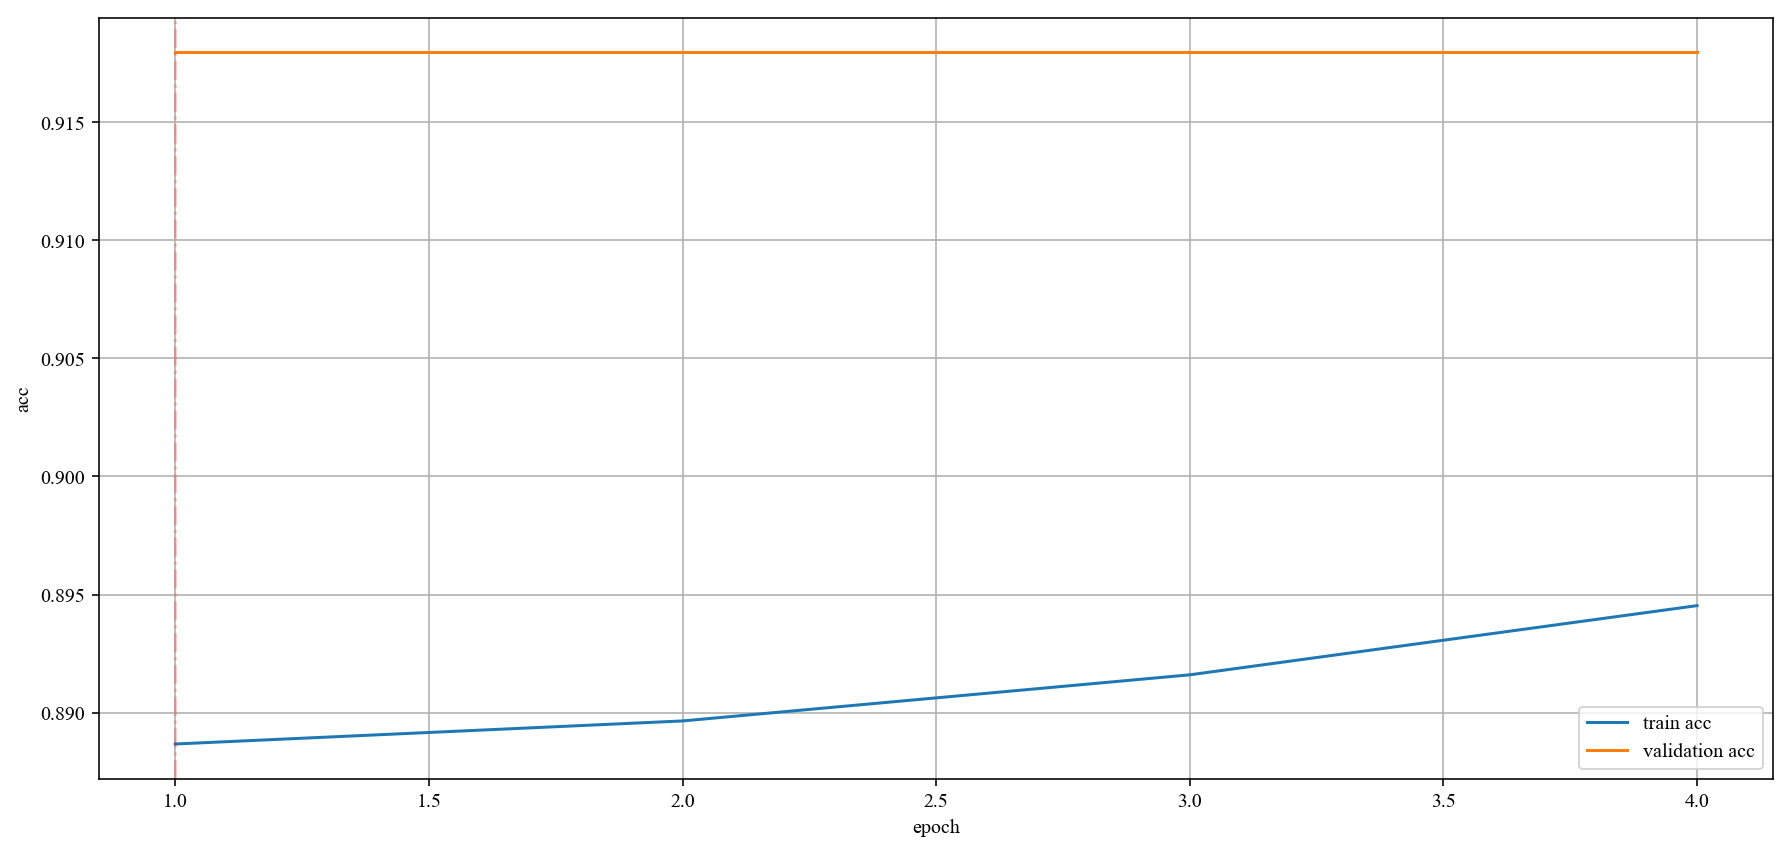

In [41]:
th.plot_history('acc')

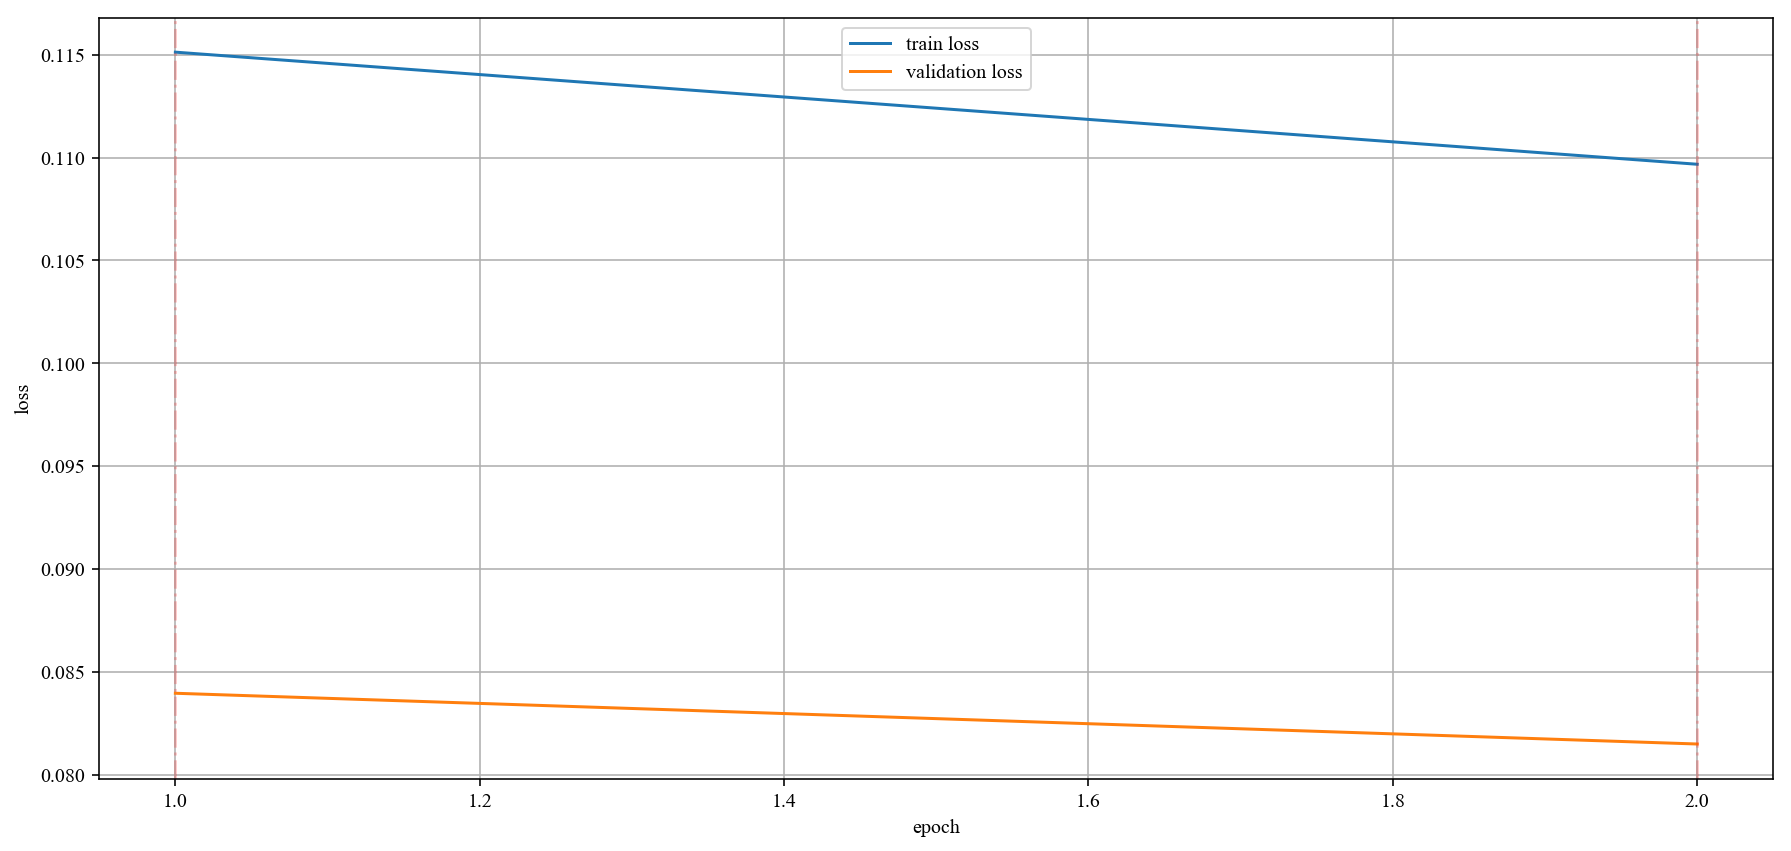

In [7]:
th.plot_history()

In [8]:
th.save('../data/harnesses/test.harness.dict')

In [9]:
th2 = TrainingHarness()
th2.load('../data/harnesses/test.harness.dict')

/Users/derekzhao/anaconda3/envs/entity-resolution/lib/python3.6/site-packages/keras/engine/topology.py:1269: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [21]:
th2.fit(epochs=10)

Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] - 10s 10ms/step - loss: 0.0900 - val_loss: 0.0796
Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] - 11s 11ms/step - loss: 0.0837 - val_loss: 0.0798
Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] - 11s 11ms/step - loss: 0.0783 - val_loss: 0.0803
Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] - 11s 11ms/step - loss: 0.0734 - val_loss: 0.0802
Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] - 11s 11ms/step - loss: 0.0685 - val_loss: 0.0802
Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] - 11s 11ms/step - loss: 0.0643 - val_loss: 0.0800
Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] 

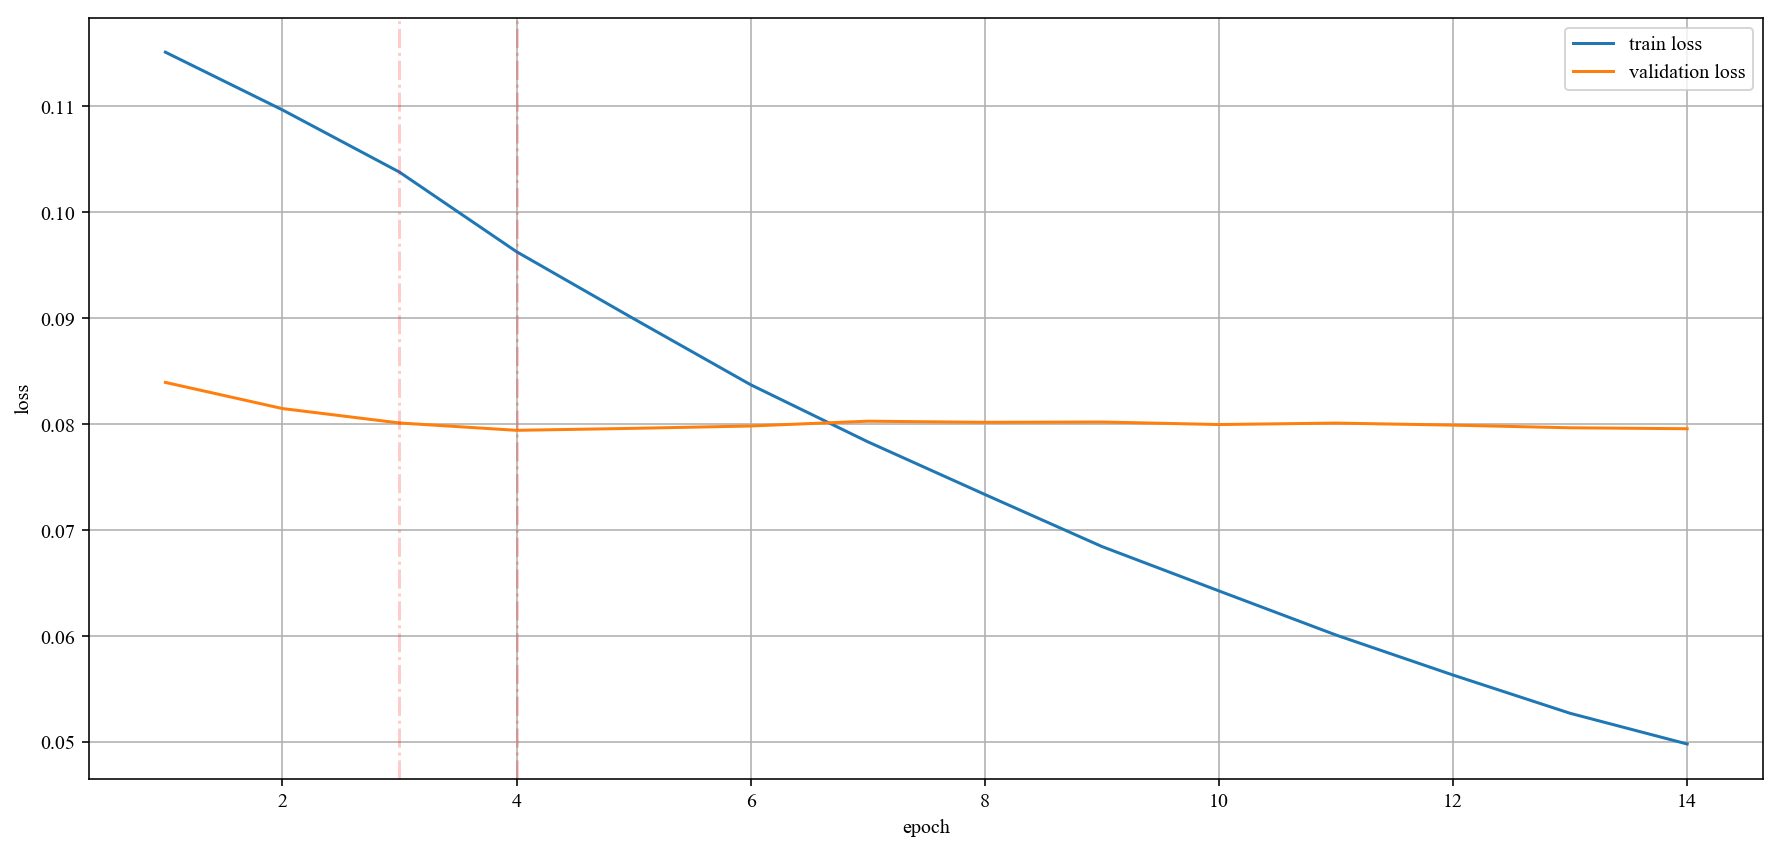

In [22]:
th2.plot_history()

In [12]:
cp_model = th2.get_checkpoint_model(-1)

/Users/derekzhao/anaconda3/envs/entity-resolution/lib/python3.6/site-packages/keras/engine/topology.py:1269: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [18]:
cp_model.fit(**fit_args)

Train on 1024 samples, validate on 512 samples
Epoch 1/1
1024/1024 [==============================] - 12s 12ms/step - loss: 0.0980 - val_loss: 0.0797


# Training Harness

In [2]:
%%writefile ../scripts/harness.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import os

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score
            
from keras.models import model_from_json

class TrainingHarness():
    """
    A TrainingHarness provides a unified means of continuously training,
    evaluating, saving, and loading models. Such a framework is ideal for
    situations where one wants to "babysit" the training of a complex
    Keras model and monitor its progress after each training period.
    
    Parameters
    ----------
    model : un-compiled Keras model, optional
        The Keras model that is to be monitored. If it is already compiled,
        it will simpy be re-compiled. The model should be permanently binded
        to its harness, as changing the model while result in unexpected
        behavior. If no model provided, then user is expected to load harness
        from a saved state.
    n_checkpoints : int, optional
        The number of checkpoints for the harness to maintain. A checkpoint
        is created each time the validation loss reaches a new minimum. Old
        checkpoints beyond "n_checkpoints" are discarded.
    npy_embedding_matrix : str
        The path and filename of the numpy matrix containing weights of
        model's embedding layer. If no file provided, it is assumed model has
        no embedding layer or embedding layer is trainable.
    compile_args : dict
        A dictionary of arguments to be passed to the model's compile function.
        Do not include "metrics", as they are handled separately by the harness.
    fit_args : dict
        A dictinoary of default arguments to be used whenever the model's
        fit function is called. The dictionary must include training and
        validation_data.
    
    Attributes
    ----------
    checkpoints : list
        List of trainable weights from models with the best validation loss.
        Each set of weights is itself a list of numpy arrays.
    checkpoint_epochs: list
        List of integers representing the epochs at which the current
        checkpoints were created.
    history : dict
        Dictionary that stores previous training and validation metrics. It is
        technically a dictionary of dictionaries; the first key is for the
        metric, and the second key is for the split ('train' or 'val'). Ex:
            - harness.history['accuracy']['val']        
    """
    
    def __init__(self, model=None, n_checkpoints = 10, npy_embedding_matrix = None,
                 compile_args=dict(loss='mean_squared_error',
                                     optimizer='adam'),
                 fit_args = None):
        
        # need location of saved numpy embedding matrix and model architecture
        # ...in order to load harness from saved state
        self.npy_embedding_matrix = npy_embedding_matrix
        
        # need compile parameters for recompiling model after reloading
        self._compile_args = compile_args
        
        if model:
            self.model = model.copy()
            self.model.compile(**compile_args)
            self._architecture = self.model.to_json()
            self._current_weights = self._get_trainable_weights()
        
        # checkpoints is a list of dictionaries of 'best' model weights
        # ...as determined by validation. the list has a max_size of
        # ...'n_checkpoints'
        self.n_checkpoints = n_checkpoints
        self.checkpoints = list()
        self.checkpoint_epochs = list()
        
        self._fit_args = dict()
        if fit_args:
            self.set_fit_args(**fit_args)
        
        self.history = dict()
        self.history['loss'] = dict(train=list(), val=list())
        if 'metrics' in list(self._compile_args.keys()):
            for key in list(self._compile_args['metrics']):
                self.history[key] = dict(train=list(), val=list())
            
        self._best_val_loss = np.inf
        
    def _get_trainable_weights(self):
        """
        Returns
        -------
        dict
            Dictionary with model's layer names as keys and lists of numpy
            weight matrices as values. Only layers designated as trainable are
            included.
        """
        keys = list()
        values = list()
        for layer in self.model.layers:
            if layer.trainable:
                keys.append(layer.name)
                values.append(layer.get_weights())
        weights = dict(zip(keys, values))
        return weights
        
    def _make_checkpoint(self):
        """
        Creates a checkpoint of trainable weights based on model's current state.
        Discards 
        """
        weights = self._get_trainable_weights()
        self.checkpoints.append(weights)
        self.checkpoint_epochs.append(len(self.history['loss']['train']))
        if len(self.checkpoints) > self.n_checkpoints:
            self.checkpoints.pop(0)
            self.checkpoint_epochs.pop(0)
        return
    
    def save(self, output_file):
        """
        Creates a dictionary of harness's attributes and saves it to specified
        location.

        Parameters
        ----------
        output_file : str
            Path and name of where to save attribute dictionary.
        """
        data = dict(compile_args = self._compile_args,
                    npy_embedding_matrix = self.npy_embedding_matrix,
                    architecture = self._architecture,
                    n_checkpoints = self.n_checkpoints,
                    checkpoints = self.checkpoints,
                    checkpoint_epochs = self.checkpoint_epochs,
                    current_weights = self._current_weights,
                    fit_args = self._fit_args,
                    history = self.history,
                    best_val_loss = self._best_val_loss)
        with open(output_file, 'wb') as f:
            pkl.dump(data, f)
                       
    def load(self, data_file):
        """
        Loads the harness from a data file of previously saved attributes.
        Automatically compiles the model based on previosly saved
        "compile_args."

        Parameters
        ----------
        data_file : str
            Path and name of pickled dictionary containing harness attributes.
        """
        with open(data_file, 'rb') as f:
            data = pkl.load(f)
            
        self.npy_embedding_matrix = data['npy_embedding_matrix']
        self._architecture = data['architecture']
            
        self._compile_args = data['compile_args']
        self.model = model_from_json(self._architecture)
        self.model.compile(**self._compile_args)
        
        self.n_checkpoints = data['n_checkpoints']
        self.checkpoints = data['checkpoints']
        self.checkpoint_epochs = data['checkpoint_epochs']
        self._current_weights = data['current_weights']
        self._fit_args = data['fit_args']
        
        self.history = data['history']
        
        self._best_val_loss = data['best_val_loss']
        
        for layer_name, weights in self._current_weights.items():
            self.model.get_layer(layer_name).set_weights(weights)
        
        if self.npy_embedding_matrix:     
            for layer in self.model.layers:
                if 'embedding' in layer.name:
                    layer.set_weights([np.load(self.npy_embedding_matrix)])
        
        self.model.compile(**self._compile_args)
        
        
    def set_fit_args(self, **args):
        """
        Updates default arguments for model fitting.
        
        Parameters
        ----------
        args : dict
            Dictionary of parameters and arguments. Only parameters specificed
            in "args" will be updated.
        """
        for arg, value in args.items():
            self._fit_args[arg] = value
            
    def set_compile_args(self, **args):
        """
        Updates default arguments for model compiling.
        
        Parameters
        ----------
        args : dict
            Dictionary of parameters and arguments. Only parameters specificed
            in "args" will be updated.
        """
        for arg, value in args.items():
            self._compile_args[args] = value
            
    def fit(self, **args):
        """
        Fits the model for a training cycle and adds training and validation
        metrics to history. If during an epoch, the validation loss reaches a
        new minimum, a checkpoint will be created.
        
        Parameters
        ----------
        args : dict
            Dictionary of parameters and arguments used to call model.fit.
            All parameters and arguments specified in "args" will not affect
            default fit settings.
            Valid parameters include:
                x : array-like or list
                    Array or list of arrays representing training features
                y : array-like
                    Training labels
                validation_data : tuple (X_val, y_val)
                    Tuple of validation training data and labels
                epochs : int
                    Number of iterations through all training data
                batch_size : int
                    Number of training instances per batch               
        """
        fit_args = self._fit_args.copy()
        for key, value in args.items():
            fit_args[key] = value
            
        history = self.model.fit(**fit_args, epochs=1)

        for metric in list(self.history.keys()):      
            self.history[metric]['train'].extend(history.history[metric])
            self.history[metric]['val'].extend(history.history['val_' + metric])

        if self.history['loss']['val'][-1] < self._best_val_loss:
            self._best_val_loss = self.history['loss']['val'][-1]
            self._make_checkpoint()
            
        self._current_weights = self._get_trainable_weights()
    
    def get_checkpoint_model(self, idx = -1):
        """
        Parameters
        ----------
        idx : int
            Index of checkpoint. Use -1 to retrieve model with most recent
            checkpointed weights. Use 0 to retrieve model with oldest remaining
            checkpointed weights.
        
        Returns
        -------
        Keras model
            A compiled model with weights corresponding to the specified
            checkpoint.
        """
        cp_model = model_from_json(self._architecture)
        cp_weights = self.checkpoints[idx]
        for layer_name, weights in cp_weights.items():
            cp_model.get_layer(layer_name).set_weights(weights)
        
        if self.npy_embedding_matrix:     
            for layer in cp_model.layers:
                if 'embedding' in layer.name:
                    layer.set_weights([np.load(self.npy_embedding_matrix)])
        cp_model.compile(**self._compile_args)
        return cp_model
        
    
    def plot_history(self, metric = 'loss', figsize = (15,7),
                     show_checkpoints = True):
        """
        Parameters
        ----------
        metric : str
            One of the five supported metrics whose history is to be plotted.
        figsize : tuple (width, height)
        show_checkpoints : bool
            Whether to plot vertical lines denoating epochs of current
            checkpoints.
        
        Returns
        -------
        matplotlib Axis
            An axis for the plot of training and validation histories
        """
        plt.figure(figsize = figsize)
        ax = plt.gca()
        train_metric = self.history[metric]['train']
        val_metric = self.history[metric]['val']
        ax.plot(range(1, len(train_metric) + 1), train_metric, label = 'train {}'.format(metric))
        ax.plot(range(1, len(val_metric) + 1), val_metric, label = 'validation {}'.format(metric))
        ax.set(xlabel = 'epoch', ylabel = metric)
        ax.grid(True)
        ax.legend()
        
        if show_checkpoints:
            for epoch in self.checkpoint_epochs:
                ax.axvline(epoch, alpha=0.2, color='red', ls='dashdot')
        return ax
    
    def clear_history(self):
        """
        Clears all history and checkpoint-related data. Useful for resetting
        harness after its model has been pre-trained.
        """
        for metric, values_dict in self.history.items():
            for split, values in values_dict.items():
                self.history[metric][split].clear()
                
        self._best_val_loss = np.inf
        self.checkpoints.clear()
        self.checkpoint_epochs.clear()
        

Overwriting ../scripts/harness.py
